In [1]:
from qutip import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [5]:
w1 = 1
w2 = 0.5
m = 1

In [100]:
def sho_eqns(t, vars, w, m=1):
    
    var_x, var_p, cov_xp = vars
    d_var_x = 2/m * cov_xp
    d_var_p = -2*m*w**2 * cov_xp
    d_cov_xp = 1/m * var_p - m*w**2 * var_x 
    return [d_var_x,d_var_p,d_cov_xp]

In [101]:
T1 = (2*np.pi)/w1
T2 = (2*np.pi)/w2
tau1= T1/4
tau2= T2/4

t_span_w1 = [0,tau1]
t_span_w2 = [tau1,tau2]

var_x0 = 1/(2*m*w1)
var_p0 = m*w1/2
cov_xp0 = 0
y0 = [var_x0, var_p0, cov_xp0]

t_eval_seg1 = np.linspace(*t_span_w1,10)
t_eval_seg2 = np.linspace(*t_span_w2,10)

In [122]:
seg_1 = solve_ivp(sho_eqns, t_span_w1, y0,t_eval=t_eval_seg1,args=(w1,m))
var_x1 = seg_1.y[0][-1]
var_p1 = seg_1.y[1][-1]
cov_xp1 = seg_1.y[2][-1]
y1 = [var_x1, var_p1, cov_xp1]

seg_2 = solve_ivp(sho_eqns, t_span_w2, y1, t_eval=t_eval_seg2, args=(w2,m))

t_full = np.concatenate([seg_1.t, seg_2.t[1:]])
y_full = np.hstack([seg_1.y, seg_2.y[:, 1:]])


seg_2.t


array([1.57079633, 1.74532925, 1.91986218, 2.0943951 , 2.26892803,
       2.44346095, 2.61799388, 2.7925268 , 2.96705973, 3.14159265])

In [121]:
seg_2.t[1:]

array([1.74532925, 1.91986218, 2.0943951 , 2.26892803, 2.44346095,
       2.61799388, 2.7925268 , 2.96705973, 3.14159265])

In [103]:
seg_2.y

array([[0.5       , 0.51139354, 0.54523062, 0.60047079, 0.6754092 ,
        0.76782804, 0.87497902, 0.99357935, 1.11988109, 1.25011521],
       [0.5       , 0.49715162, 0.48869235, 0.4748823 , 0.4561477 ,
        0.43304299, 0.40625525, 0.37660516, 0.34502973, 0.3124712 ],
       [0.        , 0.0651189 , 0.12825774, 0.18751701, 0.24110708,
        0.28733775, 0.32480388, 0.35239765, 0.36930312, 0.37498991]])

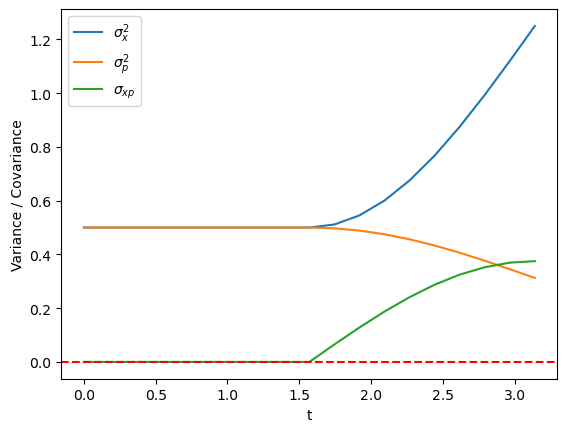

In [104]:
plt.plot(t_full, y_full[0], label=r'$\sigma_x^2$')
plt.plot(t_full, y_full[1], label=r'$\sigma_p^2$')
plt.plot(t_full, y_full[2], label=r'$\sigma_{xp}$')
plt.xlabel("t")
plt.axhline(y=0, color='r', linestyle='--')
plt.ylabel("Variance / Covariance")
plt.legend()
plt.show()

In [127]:
def ode_piecewise(cycles, w1, w2,n):
    T1 = (2*np.pi)/w1
    T2 = (2*np.pi)/w2
    tau1= T1/4
    tau2= T2/4

    var_x0 = 1/(2*m*w1)
    var_p0 = m*w1/2
    cov_xp0 = 0
    y0 = [var_x0, var_p0, cov_xp0]
    t_span_w1 = [0,tau1]
    t_span_w2 = [tau1,tau2]

    t_eval_seg1 = np.linspace(*t_span_w1,n)
    t_eval_seg2 = np.linspace(*t_span_w2,n)
    
    seg_tot = []
    t_tot_list = []
    y_tot_list = []
    while cycles:
        seg_1 = solve_ivp(sho_eqns, t_span_w1, y0,t_eval=t_eval_seg1,args=(w1,m))
        y1 = seg_1.y[:, -1]
        
        seg_2 = solve_ivp(sho_eqns, t_span_w2, y1, t_eval=t_eval_seg2, args=(w2,m))
        
        seg_tot.append(seg_1)
        seg_tot.append(seg_2)
        
        y0 = seg_2.y[:, -1]
        t_span_w1 = [t_span_w2[1],tau1+t_span_w2[1]]
        t_span_w2 = [t_span_w1[1],tau2+t_span_w1[1]]

        t_eval_seg1 = np.linspace(*t_span_w1,n)
        t_eval_seg2 = np.linspace(*t_span_w2,n)
        
        cycles -= 1 
        
    for index, seg in enumerate(seg_tot):
        if index == 0:
            t_tot_list.append(seg.t)
            y_tot_list.append(seg.y)
        else:
            t_tot_list.append(seg.t[1:])
            y_tot_list.append(seg.y[:, 1:])
            
    t_tot = np.concatenate(t_tot_list)
    y_tot = np.hstack(y_tot_list)
    return t_tot, y_tot

        

In [130]:
t_tot, y_tot = ode_piecewise(2, w1, w2,10)

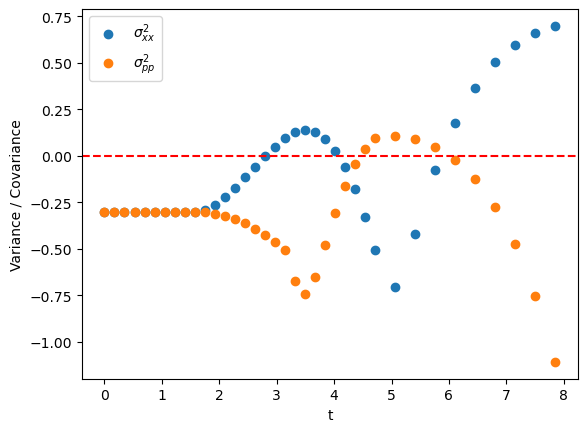

In [131]:
plt.scatter(t_tot, np.log10(y_tot[0]), label=r'$\sigma_{xx}^2$')
plt.scatter(t_tot, np.log10(y_tot[1]), label=r'$\sigma_{pp}^2$')
#plt.plot(t_tot, y_tot[2], label=r'$\sigma_{xp}$')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("t")
plt.ylabel("Variance / Covariance")
plt.legend()
plt.show()

In [85]:
def iho_eqns(t, vars, w, m=1):
    
    var_x, var_p, cov_xp = vars
    d_var_x = 2/m * cov_xp
    d_var_p = 2*m*w * cov_xp
    d_cov_xp = 1/m * var_p + m*w**2 * var_x 
    return [d_var_x,d_var_p,d_cov_xp]

In [90]:
def iho_ode_piecewise(cycles, w1, w2,n):
    T1 = (2*np.pi)/w1
    T2 = (2*np.pi)/w2
    tau1= T1/4
    tau2= T2/4

    var_x0 = 1/(2*m*w1)
    var_p0 = m*w1/2
    cov_xp0 = 0
    y0 = [var_x0, var_p0, cov_xp0]
    t_span_w1 = [0,tau1]
    t_span_w2 = [tau1,tau2]

    t_eval_seg1 = np.linspace(*t_span_w1,n)
    t_eval_seg2 = np.linspace(*t_span_w2,n)
    
    seg_tot = []
    t_tot_list = []
    y_tot_list = []
    while cycles:
        seg_1 = solve_ivp(sho_eqns, t_span_w1, y0,t_eval=t_eval_seg1,args=(w1,m))
        y1 = seg_1.y[:, -1]
        
        seg_2 = solve_ivp(iho_eqns, t_span_w2, y1, t_eval=t_eval_seg2, args=(w2,m))
        
        seg_tot.append(seg_1)
        seg_tot.append(seg_2)
        
        y0 = seg_2.y[:, -1]
        t_span_w1 = [t_span_w2[1],tau1+t_span_w2[1]]
        t_span_w2 = [t_span_w1[1],tau2+t_span_w1[1]]

        t_eval_seg1 = np.linspace(*t_span_w1,n)
        t_eval_seg2 = np.linspace(*t_span_w2,n)
        
        cycles -= 1 
    for index, seg in enumerate(seg_tot):
        if index == 0:
            t_tot_list.append(seg.t)
            y_tot_list.append(seg.y)
        else:
            t_tot_list.append(seg.t[1:])
            y_tot_list.append(seg.y[:, 1:])
            
    t_tot = np.concatenate(t_tot_list)
    y_tot = np.hstack(y_tot_list)
    return t_tot, y_tot

        

In [95]:
t_tot_iho, y_tot_iho = ode_piecewise(1, w1, w2,100)